In [148]:
import pandas as pd
import numpy as np
import riskfolio as rp
import matplotlib.pyplot as plt
import pypfopt as ppo
import sqlite3
import os
import holidays

In [149]:
ibov_close = pd.read_csv('./data/ativos_ibov/ivob_close.csv')

threshold = len(ibov_close)
ibov_close.dropna(thresh=threshold, axis=1, inplace=True)

ibov_close['Date'] = pd.to_datetime(ibov_close['Date'])

ibov_close.set_index('Date', inplace=True)
ibov_close = ibov_close.loc['2002-09-05':'2010-12-31']
returns = ibov_close.pct_change().dropna()

In [150]:
# Portfolio simples com rp
port = rp.Portfolio(returns=returns)

method_mu='hist'    # Method to estimate expected returns based on historical data.
method_cov='hist'   # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

model='Classic'     # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV'           # Risk measure used, this time will be variance
obj = 'MinRisk'     # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True         # Use historical scenarios for risk measures that depend on scenarios
rf = 0              # Risk free rate
l = 0               # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,BBAS3.SA,BBDC3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CMIG4.SA,CPFE3.SA,CPLE6.SA,CSNA3.SA,CYRE3.SA,...,GOAU4.SA,ITSA4.SA,PETR3.SA,PETR4.SA,SBSP3.SA,TRPL4.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA
weights,1.860387e-10,0.044268,2.235854e-10,0.13043,0.000089,3.503039e-10,8.646968e-11,0.012948,9.926873e-11,0.000125,...,1.146615e-10,2.268153e-10,2.436457e-09,0.042574,0.031094,0.051398,8.042045e-11,1.977400e-09,0.303028,0.200227


In [152]:
brazil_holidays = holidays.Brazil()

# Filter the data for the first 10 years
first_year_data = ibov_close.loc['2000-01-01':'2010-12-31']

weights_df = pd.DataFrame()

# Loop through each month and calculate the weights
for month in pd.date_range(start='2000-01-01', end='2010-12-31', freq='ME'):
    # Adjust the date to the next business day if it falls on a weekend or holiday
    while month.weekday() >= 5 or month in brazil_holidays or month.is_year_end:  # 5 = Saturday, 6 = Sunday
        month += pd.offsets.BDay(1)
    
    # Get the data for the current month
    monthly_data = first_year_data.loc[:month.strftime('%Y-%m-%d')]
    
    # Calculate returns for the current month
    monthly_returns = monthly_data.pct_change().dropna()
    
    # Drop rows with NaNs or infinite values
    monthly_returns = monthly_returns.replace([np.inf, -np.inf], np.nan).dropna()

    # Build the portfolio object
    port = rp.Portfolio(returns=monthly_returns)
    
    # Calculate optimal portfolio
    port.assets_stats(method_mu=method_mu, method_cov=method_cov)
    w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    
    # Store the weights in the dataframe
    w = w.T
    w['Date'] = month
    w.set_index('Date', inplace=True)
    weights_df = pd.concat([weights_df, w])

weights_df

C:\Users\loren\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\loren\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\loren\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\riskfolio\src\ParamsEstimation.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(X, rowvar=False)
C:\Users\loren\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fac

ValueError: array must not contain infs or NaNs

In [136]:
# Reindex the weights dataframe to match the index of the returns dataframe and fill missing values with the previous ones
weights_df = weights_df.reindex(returns.index, method='ffill')
weights_df = weights_df.dropna()

# Display the reindexed weights dataframe
weights_df

,BBAS3.SA,BBDC3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CMIG4.SA,CPFE3.SA,CPLE6.SA,CSNA3.SA,CYRE3.SA,...,GOAU4.SA,ITSA4.SA,PETR3.SA,PETR4.SA,SBSP3.SA,TRPL4.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2002-09-04,0.022703,0.022298,0.010299,0.06876,0.039017,1.436123e-09,0.012379,4.736950e-10,0.01485,0.154821,...,0.049089,3.615457e-09,0.039021,0.045615,0.000688,1.644689e-10,2.338947e-10,0.125246,0.038958,0.321372


In [135]:
# Filter returns to have the same dates as weights_df
filtered_returns = returns.loc[weights_df.index]
filtered_returns

,BBAS3.SA,BBDC3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CMIG4.SA,CPFE3.SA,CPLE6.SA,CSNA3.SA,CYRE3.SA,...,GOAU4.SA,ITSA4.SA,PETR3.SA,PETR4.SA,SBSP3.SA,TRPL4.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,-0.001264,-0.009435,0.000000,-0.092308,-0.050000,-0.042254,0.000000,-0.051948,-0.025000,-0.018182,...,0.000000,-0.034089,0.017964,-0.016769,0.010114,0.013258,-0.009434,0.000000,-0.019986,-0.017860
2000-02-01,0.000000,-0.016667,-0.066667,-0.067790,0.039421,0.022876,0.000000,0.000685,-0.034616,0.000000,...,-0.011494,0.023529,0.029412,0.019408,-0.025031,-0.028037,0.019047,-0.020834,0.027960,0.018185
2000-02-02,-0.010126,0.008474,0.000000,0.000000,-0.032812,-0.009584,0.000000,0.006161,-0.026561,-0.037037,...,-0.011628,0.000000,0.021428,0.019231,0.025674,-0.036539,0.000000,-0.042553,0.020800,0.000000
2000-02-03,0.010230,0.049220,0.071429,0.054545,-0.005288,-0.006774,0.000000,0.010884,0.054570,0.000000,...,0.005882,-0.005748,0.057343,0.028302,0.005006,0.017964,0.000000,0.000000,0.043887,0.000000
2000-02-04,0.012658,-0.012585,0.000000,0.000000,-0.000053,-0.002923,0.000000,0.030283,0.024580,0.000000,...,0.017544,0.011561,0.029101,0.025321,0.009907,0.058824,0.042056,0.037777,0.018019,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-23,0.011200,-0.001946,-0.000448,0.007667,0.014098,-0.011068,0.001225,-0.000734,0.001485,-0.001973,...,-0.007272,0.000000,0.001755,0.001166,0.009099,0.017400,-0.006806,-0.003156,-0.010833,-0.006320
2010-12-27,-0.006122,-0.017544,-0.028238,-0.014493,0.022840,-0.012315,-0.002937,-0.011520,-0.008528,-0.011858,...,-0.018316,-0.019231,0.007007,0.011650,0.002480,-0.015302,-0.014233,-0.028496,0.006945,-0.014085
2010-12-28,-0.001945,-0.003968,-0.015221,0.012500,-0.009709,0.025689,0.002455,0.000496,-0.007853,0.024500,...,-0.019776,0.003921,0.030272,0.023417,0.014396,0.003108,-0.020855,-0.008872,0.015916,0.000000


In [133]:
# Calculate the portfolio returns
portfolio_returns = (filtered_returns * weights_df).sum(axis=1)
portfolio_returns[portfolio_returns>1]

Date
2002-09-04    9.427411
dtype: float64

In [122]:
# Normalize the portfolio returns to start at 1
normalized_portfolio_returns = (1 + portfolio_returns).cumprod()
normalized_portfolio_returns

Date
2000-01-31      0.992702
2000-02-01      0.991139
2000-02-02      0.983534
2000-02-03      0.990833
2000-02-04      0.997966
                 ...    
2010-12-23    329.638842
2010-12-27    326.721678
2010-12-28    329.373886
2010-12-29    332.315113
2010-12-30    333.252494
Length: 2780, dtype: float64

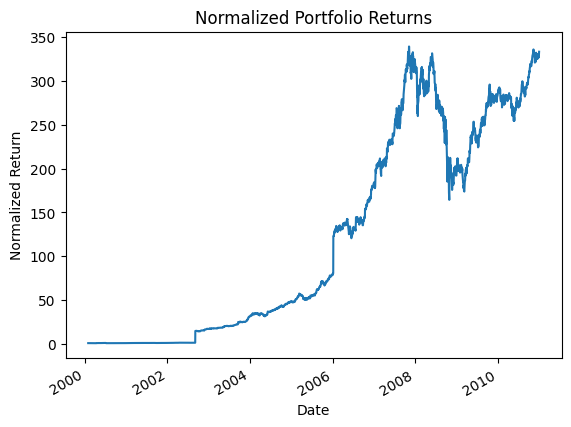

In [123]:
# Plot the normalized portfolio returns
normalized_portfolio_returns.plot(title='Normalized Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.show()

In [124]:
# Generate a binary array with 150 ones randomly distributed
binary_array = np.zeros(len(ibov_close.index), dtype=int)
binary_array[:150] = 1
np.random.shuffle(binary_array)

# Combine the binary array with the dates
rebalancing_dates = ibov_close.index[binary_array == 1]

# Filter the data for the first 10 years
first_ten_years_data = ibov_close.loc['2000-01-01':'2010-12-31']

# Initialize an empty dataframe to store the weights
new_weights_df = pd.DataFrame()

# Loop through each rebalancing date and calculate the weights
for date in rebalancing_dates:
    if date > pd.Timestamp('2010-12-31'):
        continue
    
    # Get the data up to the current rebalancing date
    rebalancing_data = first_ten_years_data.loc[:date.strftime('%Y-%m-%d')]
    
    # Calculate returns for the current period
    rebalancing_returns = rebalancing_data.pct_change().dropna()
    
    # Build the portfolio object
    port = rp.Portfolio(returns=rebalancing_returns)
    
    # Calculate optimal portfolio
    port.assets_stats(method_mu=method_mu, method_cov=method_cov)
    w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    
    # Store the weights in the dataframe
    w = w.T
    w['Date'] = date
    w.set_index('Date', inplace=True)
    new_weights_df = pd.concat([weights_df, w])

# Display the weights dataframe
new_weights_df

You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix


,BBAS3.SA,BBDC3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CMIG4.SA,CPFE3.SA,CPLE6.SA,CSNA3.SA,CYRE3.SA,...,GOAU4.SA,ITSA4.SA,PETR3.SA,PETR4.SA,SBSP3.SA,TRPL4.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,1.056487e-01,2.307020e-10,5.318593e-02,5.844786e-11,0.06275,0.015161,0.175339,1.479111e-10,3.593768e-02,0.091576,...,0.200870,1.790006e-10,2.808386e-10,0.056828,2.787488e-10,6.460927e-11,5.954642e-11,7.792231e-11,1.189329e-10,0.151958
2000-02-01,1.056487e-01,2.307020e-10,5.318593e-02,5.844786e-11,0.06275,0.015161,0.175339,1.479111e-10,3.593768e-02,0.091576,...,0.200870,1.790006e-10,2.808386e-10,0.056828,2.787488e-10,6.460927e-11,5.954642e-11,7.792231e-11,1.189329e-10,0.151958
2000-02-02,1.056487e-01,2.307020e-10,5.318593e-02,5.844786e-11,0.06275,0.015161,0.175339,1.479111e-10,3.593768e-02,0.091576,...,0.200870,1.790006e-10,2.808386e-10,0.056828,2.787488e-10,6.460927e-11,5.954642e-11,7.792231e-11,1.189329e-10,0.151958
2000-02-03,1.056487e-01,2.307020e-10,5.318593e-02,5.844786e-11,0.06275,0.015161,0.175339,1.479111e-10,3.593768e-02,0.091576,...,0.200870,1.790006e-10,2.808386e-10,0.056828,2.787488e-10,6.460927e-11,5.954642e-11,7.792231e-11,1.189329e-10,0.151958
2000-02-04,1.056487e-01,2.307020e-10,5.318593e-02,5.844786e-11,0.06275,0.015161,0.175339,1.479111e-10,3.593768e-02,0.091576,...,0.200870,1.790006e-10,2.808386e-10,0.056828,2.787488e-10,6.460927e-11,5.954642e-11,7.792231e-11,1.189329e-10,0.151958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-27,1.417982e-09,3.919715e-02,1.038711e-09,1.155537e-01,0.00002,0.000410,0.000165,1.743037e-02,7.197705e-10,0.028884,...,0.013706,1.713164e-09,8.167517e-03,0.052174,3.620703e-02,3.187279e-02,4.892068e-10,4.401394e-02,2.502140e-01,0.253087
2010-12-28,1.417982e-09,3.919715e-02,1.038711e-09,1.155537e-01,0.00002,0.000410,0.000165,1.743037e-02,7.197705e-10,0.028884,...,0.013706,1.713164e-09,8.167517e-03,0.052174,3.620703e-02,3.187279e-02,4.892068e-10,4.401394e-02,2.502140e-01,0.253087
2010-12-29,1.417982e-09,3.919715e-02,1.038711e-09,1.155537e-01,0.00002,0.000410,0.000165,1.743037e-02,7.197705e-10,0.028884,...,0.013706,1.713164e-09,8.167517e-03,0.052174,3.620703e-02,3.187279e-02,4.892068e-10,4.401394e-02,2.502140e-01,0.253087


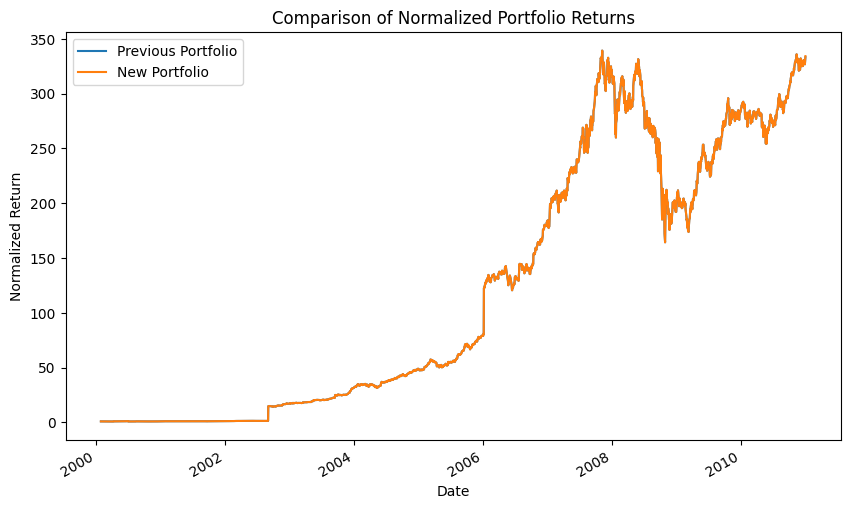

In [125]:
# Filter returns to have the same dates as weights_df
new_filtered_returns = returns.loc[new_weights_df.index]
new_filtered_returns

# Calculate the new portfolio returns
new_portfolio_returns = (new_filtered_returns * new_weights_df).sum(axis=1)

# Normalize the new portfolio returns to start at 1
new_normalized_portfolio_returns = (1 + new_portfolio_returns).cumprod()

# Plot both portfolios
plt.figure(figsize=(10, 6))
normalized_portfolio_returns.plot(label='Previous Portfolio')
new_normalized_portfolio_returns.plot(label='New Portfolio')
plt.title('Comparison of Normalized Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.legend()
plt.show()